# Discriminative Project Milstone 3

# Setup

In [1]:
from google.colab import files
import zipfile

# Upload
uploaded = files.upload()

with zipfile.ZipFile('data_train.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Saving data_train.zip to data_train.zip


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
import shutil
import random
import yaml
from PIL import Image
from collections import defaultdict
from pathlib import Path
import time
import warnings

warnings.filterwarnings('ignore')

print("Installing/Updating Ultralytics (YOLOv8)...")
import subprocess
subprocess.check_call(['pip', 'install', '-q', 'ultralytics'])

from ultralytics import YOLO
print("Ultralytics installed")

Installing/Updating Ultralytics (YOLOv8)...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics installed


In [15]:
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.09 GB


In [4]:
ZIP_FILE_PATH = '/content/data_train.zip'
EXTRACT_DIR = '/content/dataset_raw'
PROCESSED_DIR = '/content/dataset_processed'
YOLO_DATASET_DIR = '/content/yolo_dataset'
OUTPUT_DIR = '/content/yolo_output'

# Image settings
SINGLE_OBJECT_SIZE = (224, 224)  # Original single-object image size
CANVAS_SIZE = (640, 640)         # YOLO input size
SUPPORTED_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.heic', '.heif', '.bmp', '.webp'}

# Concatenation settings
MIN_OBJECTS_PER_IMAGE = 2
MAX_OBJECTS_PER_IMAGE = 5
OBJECT_SCALE_RANGE = (0.15, 0.35)  # Object size relative to canvas (smaller for more objects)
MAX_PLACEMENT_ATTEMPTS = 50
MIN_OBJECT_SIZE = 40              # Minimum object size in pixels
MAX_OVERLAP_IOU = 0.0             # No overlap allowed

# Dataset split
NUM_TRAIN_IMAGES = 3500
NUM_VAL_IMAGES = 400
NUM_TEST_IMAGES = 100

# Training settings
YOLO_MODEL = 'yolov8s.pt'  # Small model, good balance
EPOCHS = 50
BATCH_SIZE = 16
IMAGE_SIZE = 640

# Create directories
for dir_path in [EXTRACT_DIR, PROCESSED_DIR, YOLO_DATASET_DIR, OUTPUT_DIR]:
    os.makedirs(dir_path, exist_ok=True)


In [5]:
# OBJxxx -> readable name (for reference)
CLASS_MAPPING = {
    'OBJ001': 'Trigger Wallet',
    'OBJ002': 'Water Bottle-Grey',
    'OBJ003': 'Ear buds',
    'OBJ004': 'Book(Sky blue, Hardcover)',
    'OBJ005': 'Notebook(Spiral)',
    'OBJ006': 'hair_pin',
    'OBJ007': 'Northeastern husky stuffed toy',
    'OBJ008': 'Glasses',
    'OBJ009': 'Computer Mouse',
    'OBJ010': 'Scientific Calculator',
    'OBJ012': 'Watch - Apple',
    'OBJ016': 'Pen',
    'OBJ018': 'Water Bottle-Hydrapeak (Mint Green)',
    'OBJ019': 'Earphone Case - SkullCandy',
    'OBJ021': 'Moisturizer Bottle',
    'OBJ022': 'wallet',
    'OBJ027': 'Hulk Toy',
    'OBJ028': 'popmart key chain toy',
    'OBJ029': 'Hair Scrunchie',
    'OBJ031': 'Apple',
    'OBJ061': 'Coca Cola',
    'OBJ069': 'ceramic skull',
    'OBJ090': 'Backpack',
    'OBJ095': 'men watch',
    'OBJ107': 'Water bottle - black',
    'OBJ108': 'remote',
    'OBJ111': 'laptop_sleeve',
    'OBJ159': 'Headphones - Sony',
    'OBJ208': 'Coffee Mug',
    'OBJ222': 'Circular Tiffin box',
    'OBJ229': 'Banana',
    'OBJ230': 'protien bar',
    'OBJ300': 'Deodrant Bottle',
    'OBJ311': 'Lipstick - Sephora',
    'OBJ405': 'Halloween Decoration Skull',
    'OBJ786': 'Perfume',
    'OBJ787': 'Lego Red bull car',
    'OBJ788': 'Lego Plant',
    'OBJ789': 'Ceramic Cat',
}

# Create sorted class list for YOLO (class_id -> OBJxxx)
CLASS_IDS = sorted(CLASS_MAPPING.keys())  # Sorted for consistent ordering
NUM_CLASSES = len(CLASS_IDS)

# Create mappings
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_IDS)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print("\n" + "=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"Zip file:              {ZIP_FILE_PATH}")
print(f"Canvas size:           {CANVAS_SIZE}")
print(f"Objects per image:     {MIN_OBJECTS_PER_IMAGE}-{MAX_OBJECTS_PER_IMAGE}")
print(f"Number of classes:     {NUM_CLASSES}")
print(f"Dataset split:         {NUM_TRAIN_IMAGES} train / {NUM_VAL_IMAGES} val / {NUM_TEST_IMAGES} test")
print(f"YOLO model:            {YOLO_MODEL}")
print(f"Training epochs:       {EPOCHS}")
print(f"Batch size:            {BATCH_SIZE}")
print(f"Device:                {device}")

print("\n" + "-" * 60)
print("CLASS ID MAPPING (first 10)")
print("-" * 60)
for idx, cls in enumerate(CLASS_IDS[:10]):
    print(f"  {idx:2d} -> {cls} ({CLASS_MAPPING[cls]})")
print(f"  ... ({NUM_CLASSES - 10} more classes)")


CONFIGURATION
Zip file:              /content/data_train.zip
Canvas size:           (640, 640)
Objects per image:     2-5
Number of classes:     39
Dataset split:         3500 train / 400 val / 100 test
YOLO model:            yolov8s.pt
Training epochs:       50
Batch size:            16
Device:                cuda

------------------------------------------------------------
CLASS ID MAPPING (first 10)
------------------------------------------------------------
   0 -> OBJ001 (Trigger Wallet)
   1 -> OBJ002 (Water Bottle-Grey)
   2 -> OBJ003 (Ear buds)
   3 -> OBJ004 (Book(Sky blue, Hardcover))
   4 -> OBJ005 (Notebook(Spiral))
   5 -> OBJ006 (hair_pin)
   6 -> OBJ007 (Northeastern husky stuffed toy)
   7 -> OBJ008 (Glasses)
   8 -> OBJ009 (Computer Mouse)
   9 -> OBJ010 (Scientific Calculator)
  ... (29 more classes)


# Data Extraction & Preprocessing

In [6]:
# HEIC Support Installation

def install_heic_support():
    """Install pillow-heif for HEIC/HEIF format support."""
    try:
        import pillow_heif
        pillow_heif.register_heif_opener()
        print("HEIC support available")
    except ImportError:
        print("Installing pillow-heif for HEIC support...")
        subprocess.check_call(['pip', 'install', 'pillow-heif', '-q'])
        import pillow_heif
        pillow_heif.register_heif_opener()
        print("HEIC support installed")

install_heic_support()

# Extract and Preprocess Single-Object Images

def extract_and_preprocess(zip_path, extract_dir, processed_dir, target_size=SINGLE_OBJECT_SIZE):
    """
    Extract zip and preprocess all single-object images.

    Args:
        zip_path: Path to uploaded zip file
        extract_dir: Directory for raw extraction
        processed_dir: Directory for processed images
        target_size: Target image size (224, 224)

    Returns:
        dict: Statistics and class information
    """
    import re

    stats = {
        'total_found': 0,
        'total_processed': 0,
        'skipped_errors': 0,
        'classes': defaultdict(int),
        'class_images': defaultdict(list),  # Store image paths per class
        'errors': []
    }

    # Clean up previous runs
    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    if os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)

    os.makedirs(extract_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)

    # Extract zip file
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(" Extraction complete")

    # Match folder names like OBJ001, OBJ002, etc. (without images_ prefix)
    # Supports both "OBJ001" and "images_OBJ001" patterns
    folder_pattern = re.compile(r'^(?:images_)?OBJ(\d{3})$', re.IGNORECASE)

    class_folders = []
    for root, dirs, files in os.walk(extract_dir):
        for dir_name in dirs:
            match = folder_pattern.match(dir_name)
            if match:
                class_id = f"OBJ{match.group(1)}"
                full_path = os.path.join(root, dir_name)
                class_folders.append((class_id, full_path))

    print(f"Found {len(class_folders)} class folders")

    if len(class_folders) == 0:
        print(" WARNING: No class folders found!")
        print("Expected folder names like: OBJ001, OBJ002, ... or images_OBJ001, ...")

        # Debug: Show what folders were found
        print("\nFolders found in extracted directory:")
        for root, dirs, files in os.walk(extract_dir):
            for d in dirs[:15]:
                print(f"  {d}")
            if len(dirs) > 15:
                print(f"  ... and {len(dirs) - 15} more")
            break
        return stats

    # Process each class folder
    print("\nProcessing images...")

    for class_id, folder_path in sorted(class_folders):
        # Skip if class not in our mapping
        if class_id not in CLASS_MAPPING:
            print(f"  Skipping unknown class: {class_id}")
            continue

        # Create output folder for this class
        class_output_dir = os.path.join(processed_dir, class_id)
        os.makedirs(class_output_dir, exist_ok=True)

        image_count = 0

        for filename in os.listdir(folder_path):
            file_ext = os.path.splitext(filename)[1].lower()

            if file_ext not in SUPPORTED_EXTENSIONS:
                continue

            stats['total_found'] += 1
            input_path = os.path.join(folder_path, filename)
            output_filename = f"{class_id}_{image_count:04d}.jpg"
            output_path = os.path.join(class_output_dir, output_filename)

            try:
                # Open image
                with Image.open(input_path) as img:
                    # Convert to RGB
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Resize to target size
                    if img.size != target_size:
                        img = img.resize(target_size, Image.LANCZOS)

                    # Save as JPG
                    img.save(output_path, 'JPEG', quality=95)

                stats['total_processed'] += 1
                stats['classes'][class_id] += 1
                stats['class_images'][class_id].append(output_path)
                image_count += 1

            except Exception as e:
                stats['skipped_errors'] += 1
                stats['errors'].append(f"{input_path}: {str(e)}")

        print(f"  {class_id}: {image_count} images")

    print("\n Preprocessing complete")
    return stats

Installing pillow-heif for HEIC support...
HEIC support installed


In [7]:
def print_preprocessing_stats(stats):
    """Print summary of preprocessing."""
    print("\n" + "=" * 60)
    print("PREPROCESSING SUMMARY")
    print("=" * 60)

    print(f"\nTotal images found:     {stats['total_found']}")
    print(f"Successfully processed: {stats['total_processed']}")
    print(f"Skipped (errors):       {stats['skipped_errors']}")
    print(f"Number of classes:      {len(stats['classes'])}")

    # Class distribution
    print("\n" + "-" * 60)
    print("CLASS DISTRIBUTION")
    print("-" * 60)

    counts = list(stats['classes'].values())
    for class_id, count in sorted(stats['classes'].items()):
        readable_name = CLASS_MAPPING.get(class_id, 'Unknown')
        print(f"  {class_id} ({readable_name[:20]:<20}): {count:4d} images")

    if counts:
        print("\n" + "-" * 60)
        print(f"  Min images per class: {min(counts)}")
        print(f"  Max images per class: {max(counts)}")
        print(f"  Avg images per class: {sum(counts)/len(counts):.1f}")

    if stats['errors']:
        print("\n" + "-" * 60)
        print(f"ERRORS ({len(stats['errors'])} total, showing first 5)")
        print("-" * 60)
        for err in stats['errors'][:5]:
            print(f"  {err}")

# 2.4 Visualize Sample Images from Each Class

def visualize_class_samples(stats, num_classes_to_show=12, images_per_class=1):
    """Visualize sample images from different classes."""

    classes_to_show = list(stats['class_images'].keys())[:num_classes_to_show]

    cols = 4
    rows = (len(classes_to_show) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten() if rows > 1 else [axes] if rows == 1 and cols == 1 else axes

    for idx, class_id in enumerate(classes_to_show):
        if stats['class_images'][class_id]:
            img_path = stats['class_images'][class_id][0]
            img = Image.open(img_path)
            axes[idx].imshow(img)
            readable_name = CLASS_MAPPING.get(class_id, 'Unknown')[:15]
            axes[idx].set_title(f"{class_id}\n{readable_name}", fontsize=9)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(classes_to_show), len(axes)):
        axes[idx].axis('off')

    plt.suptitle("Sample Single-Object Images by Class", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


Extracting /content/data_train.zip...
 Extraction complete
Found 39 class folders

Processing images...
  OBJ001: 100 images
  OBJ002: 100 images
  OBJ003: 100 images
  OBJ004: 100 images
  OBJ005: 100 images
  OBJ006: 100 images
  OBJ007: 100 images
  OBJ008: 100 images
  OBJ009: 100 images
  OBJ010: 100 images
  OBJ012: 110 images
  OBJ016: 99 images
  OBJ018: 120 images
  OBJ019: 100 images
  OBJ021: 100 images
  OBJ022: 99 images
  OBJ027: 100 images
  OBJ028: 100 images
  OBJ029: 100 images
  OBJ031: 100 images
  OBJ061: 100 images
  OBJ069: 100 images
  OBJ090: 100 images
  OBJ095: 101 images
  OBJ107: 144 images
  OBJ108: 100 images
  OBJ111: 100 images
  OBJ159: 136 images
  OBJ208: 100 images
  OBJ222: 108 images
  OBJ229: 126 images
  OBJ230: 140 images
  OBJ300: 100 images
  OBJ311: 124 images
  OBJ405: 100 images
  OBJ786: 100 images
  OBJ787: 100 images
  OBJ788: 100 images
  OBJ789: 100 images

 Preprocessing complete

PREPROCESSING SUMMARY

Total images found:     4107
S

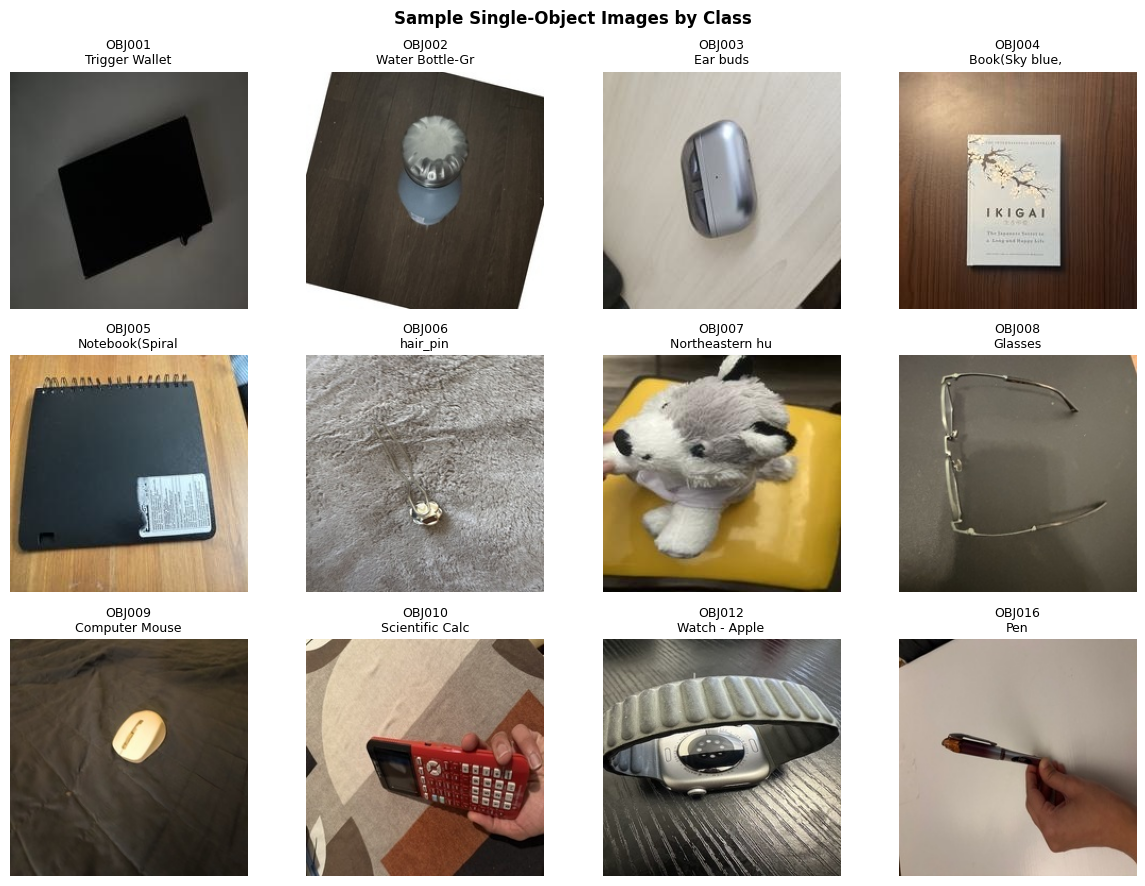

In [8]:
if os.path.exists(ZIP_FILE_PATH):
    stats = extract_and_preprocess(
        ZIP_FILE_PATH,
        EXTRACT_DIR,
        PROCESSED_DIR,
        SINGLE_OBJECT_SIZE
    )
    print_preprocessing_stats(stats)

    # Visualize samples if we have data
    if stats['total_processed'] > 0:
        print("\n" + "=" * 60)
        print("SAMPLE VISUALIZATION")
        print("=" * 60)
        visualize_class_samples(stats, num_classes_to_show=12)

    # Store for later use
    CLASS_IMAGES = stats['class_images']

else:
    print(f"Zip file not found: {ZIP_FILE_PATH}")
    print("\nPlease:")
    print("1. Upload your zip file to Colab (data_train.zip)")
    print("2. Ensure the path is correct")
    print("3. Re-run this cell")
    CLASS_IMAGES = {}

# Auto-Detection
for auto-annotation in next step



In [9]:
def detect_bbox_contour(image_path, padding=10):
    """
    Detect object bounding box using edge detection and contours.

    Args:
        image_path: Path to image
        padding: Padding around detected object

    Returns:
        tuple: (x, y, w, h) bounding box or None if failed
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None

    h, w = img.shape[:2]

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edges = cv2.Canny(blurred, 30, 100)

    # Dilate to connect edges
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=2)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Find largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding box
    x, y, bw, bh = cv2.boundingRect(largest_contour)

    # Add padding
    x = max(0, x - padding)
    y = max(0, y - padding)
    bw = min(w - x, bw + 2 * padding)
    bh = min(h - y, bh + 2 * padding)

    return (x, y, bw, bh)


def detect_bbox_grabcut(image_path, margin=10):
    """
    Detect object bounding box using GrabCut segmentation.

    Args:
        image_path: Path to image
        margin: Initial margin for GrabCut rectangle

    Returns:
        tuple: (x, y, w, h) bounding box or None if failed
    """
    img = cv2.imread(image_path)
    if img is None:
        return None

    h, w = img.shape[:2]

    # Initialize mask
    mask = np.zeros((h, w), np.uint8)

    # Initialize rectangle (slightly inside image borders)
    rect = (margin, margin, w - 2*margin, h - 2*margin)

    # Background and foreground models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    try:
        # Run GrabCut
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

        # Create binary mask
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

        # Find contours in mask
        contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            return None

        # Find largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, bw, bh = cv2.boundingRect(largest_contour)

        return (x, y, bw, bh)

    except Exception as e:
        return None


def get_center_bbox(img_width, img_height, coverage=0.80):
    """
    Fallback: Return center-based bounding box.

    Args:
        img_width: Image width
        img_height: Image height
        coverage: Fraction of image to cover (default 80%)

    Returns:
        tuple: (x, y, w, h) bounding box
    """
    margin_x = int(img_width * (1 - coverage) / 2)
    margin_y = int(img_height * (1 - coverage) / 2)

    x = margin_x
    y = margin_y
    w = img_width - 2 * margin_x
    h = img_height - 2 * margin_y

    return (x, y, w, h)

# 3.2 Main Bounding Box Detection Function
def detect_object_bbox(image_path, min_coverage=0.10, max_coverage=0.95):
    """
    Detect object bounding box with fallback strategies.

    Args:
        image_path: Path to image
        min_coverage: Minimum bbox area as fraction of image
        max_coverage: Maximum bbox area as fraction of image

    Returns:
        tuple: (x, y, w, h) bounding box
    """
    # Get image dimensions
    img = cv2.imread(image_path)
    if img is None:
        return get_center_bbox(224, 224)  # Default fallback

    h, w = img.shape[:2]
    img_area = w * h

    # Try contour detection first (faster)
    bbox = detect_bbox_contour(image_path)

    if bbox:
        x, y, bw, bh = bbox
        bbox_area = bw * bh
        coverage = bbox_area / img_area

        # Check if bbox is valid
        if min_coverage <= coverage <= max_coverage and bw > 20 and bh > 20:
            return bbox

    # Try GrabCut (slower but more accurate)
    bbox = detect_bbox_grabcut(image_path)

    if bbox:
        x, y, bw, bh = bbox
        bbox_area = bw * bh
        coverage = bbox_area / img_area

        # Check if bbox is valid
        if min_coverage <= coverage <= max_coverage and bw > 20 and bh > 20:
            return bbox

    # Fallback to center bbox
    return get_center_bbox(w, h, coverage=0.80)

# 3.3 Process All Images and Extract Bounding Boxes
def extract_all_bboxes(class_images, sample_rate=1.0):
    """
    Extract bounding boxes for all images.

    Args:
        class_images: Dict of {class_id: [image_paths]}
        sample_rate: Fraction of images to process (for testing)

    Returns:
        dict: {class_id: [(image_path, bbox), ...]}
    """
    all_bboxes = defaultdict(list)
    total_images = sum(len(paths) for paths in class_images.values())
    processed = 0

    print(f"Extracting bounding boxes for {total_images} images...")

    for class_id, image_paths in class_images.items():
        # Sample images if needed
        if sample_rate < 1.0:
            num_samples = max(1, int(len(image_paths) * sample_rate))
            image_paths = random.sample(image_paths, num_samples)

        for img_path in image_paths:
            bbox = detect_object_bbox(img_path)
            all_bboxes[class_id].append((img_path, bbox))
            processed += 1

            # Progress update
            if processed % 500 == 0:
                print(f" Processed {processed}/{total_images} images...")

    print(f"Extracted bounding boxes for {processed} images")
    return all_bboxes

#Visualize Detected Bounding Boxes

def visualize_bboxes(all_bboxes, num_samples=12):
    """Visualize detected bounding boxes on sample images."""

    # Collect samples from different classes
    samples = []
    for class_id, bbox_list in all_bboxes.items():
        if bbox_list:
            samples.append((class_id, bbox_list[0]))  # First image of each class
        if len(samples) >= num_samples:
            break

    cols = 4
    rows = (len(samples) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5 * rows))
    axes = axes.flatten()

    for idx, (class_id, (img_path, bbox)) in enumerate(samples):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Draw bounding box
        x, y, w, h = bbox
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axes[idx].imshow(img)
        readable_name = CLASS_MAPPING.get(class_id, 'Unknown')[:12]
        axes[idx].set_title(f"{class_id}\n{readable_name}\nbbox: {w}x{h}", fontsize=8)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].axis('off')

    plt.suptitle("Auto-Detected Bounding Boxes (Green)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('detected_bboxes.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: detected_bboxes.png")





Extracting bounding boxes for 4107 images...
 Processed 500/4107 images...
 Processed 1000/4107 images...
 Processed 1500/4107 images...
 Processed 2000/4107 images...
 Processed 2500/4107 images...
 Processed 3000/4107 images...
 Processed 3500/4107 images...
 Processed 4000/4107 images...
Extracted bounding boxes for 4107 images

Total bounding boxes extracted: 4107
Classes with bboxes: 39

BOUNDING BOX VISUALIZATION


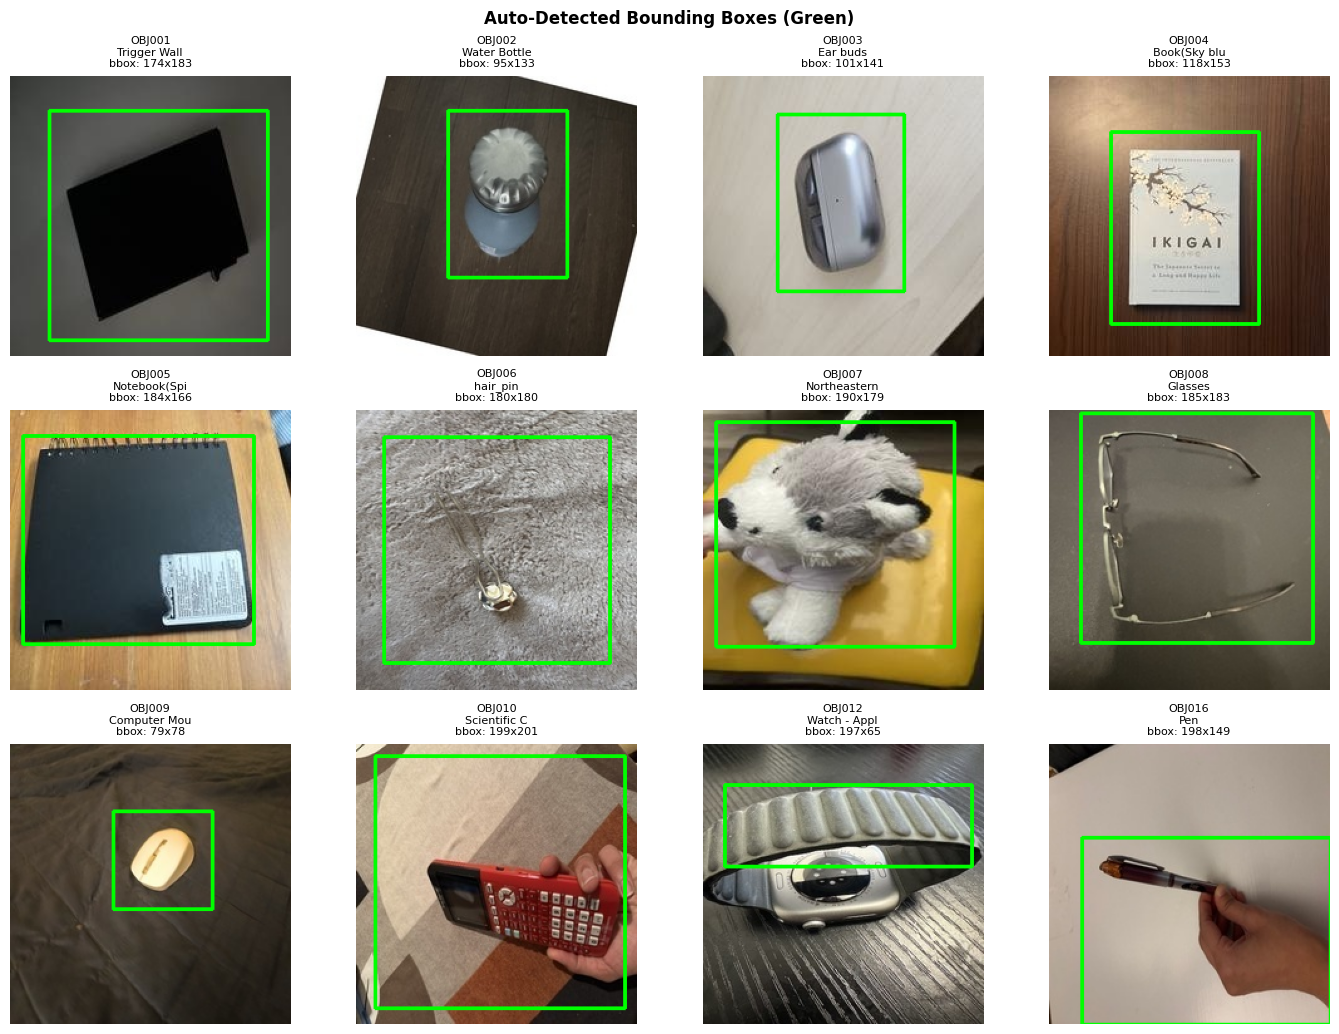

Saved: detected_bboxes.png


In [10]:
if CLASS_IMAGES and len(CLASS_IMAGES) > 0:
    # Extract bounding boxes for all images
    ALL_BBOXES = extract_all_bboxes(CLASS_IMAGES)

    # Print statistics
    total_bboxes = sum(len(v) for v in ALL_BBOXES.values())
    print(f"\nTotal bounding boxes extracted: {total_bboxes}")
    print(f"Classes with bboxes: {len(ALL_BBOXES)}")

    # Visualize samples
    print("\n" + "=" * 60)
    print("BOUNDING BOX VISUALIZATION")
    print("=" * 60)
    visualize_bboxes(ALL_BBOXES, num_samples=12)

else:
    print("No images found.")
    ALL_BBOXES = {}

# Annotation and Concatenation

In [11]:
GRID_SIZES = [2, 3, 4, 5]  # 2x2, 3x3, 4x4, 5x5 grids
GRID_WEIGHTS = [0.2, 0.4, 0.3, 0.1]  # Probability of each grid size (3x3 most common)
OUTPUT_IMAGE_SIZE = (640, 640)  # Final output size for YOLO

def select_grid_size():
    """Randomly select grid size based on weights."""
    return random.choices(GRID_SIZES, weights=GRID_WEIGHTS, k=1)[0]


def get_cell_positions(grid_size, output_size):
    """
    Calculate cell positions for a grid layout.

    Args:
        grid_size: Number of rows/cols (e.g., 3 for 3x3)
        output_size: (width, height) of output image

    Returns:
        list: [(x, y, w, h), ...] for each cell
    """
    out_w, out_h = output_size
    cell_w = out_w // grid_size
    cell_h = out_h // grid_size

    cells = []
    for row in range(grid_size):
        for col in range(grid_size):
            x = col * cell_w
            y = row * cell_h
            cells.append((x, y, cell_w, cell_h))

    return cells


def resize_and_fit(image, target_w, target_h, keep_aspect=True):
    """
    Resize image to fit within target dimensions.

    Args:
        image: PIL Image
        target_w: Target width
        target_h: Target height
        keep_aspect: Whether to maintain aspect ratio

    Returns:
        PIL.Image: Resized image
    """
    if keep_aspect:
        # Calculate scale to fit
        img_w, img_h = image.size
        scale = min(target_w / img_w, target_h / img_h)
        new_w = int(img_w * scale)
        new_h = int(img_h * scale)

        # Resize
        resized = image.resize((new_w, new_h), Image.LANCZOS)

        # Create background and paste centered
        result = Image.new('RGB', (target_w, target_h), (128, 128, 128))
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2

        if resized.mode == 'RGBA':
            result.paste(resized, (paste_x, paste_y), resized)
        else:
            result.paste(resized, (paste_x, paste_y))

        return result, (paste_x, paste_y, new_w, new_h)
    else:
        return image.resize((target_w, target_h), Image.LANCZOS), (0, 0, target_w, target_h)


def apply_cell_augmentation(img):
    """
    Apply augmentation to a single cell image.

    Args:
        img: PIL Image

    Returns:
        PIL.Image: Augmented image
    """
    # Random horizontal flip
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random brightness/contrast (subtle)
    if random.random() > 0.5:
        from PIL import ImageEnhance

        # Brightness
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.85, 1.15))

        # Contrast
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(random.uniform(0.85, 1.15))

    return img

# Estimate Object Bounding Box Within Cell

def estimate_bbox_in_cell(cell_x, cell_y, cell_w, cell_h,
                          obj_bbox, img_size, paste_offset):
    """
    Calculate object bounding box position within the final image.

    Args:
        cell_x, cell_y: Cell position in output image
        cell_w, cell_h: Cell dimensions
        obj_bbox: Original object bbox (x, y, w, h) in source image
        img_size: Original image size (w, h)
        paste_offset: (paste_x, paste_y, new_w, new_h) from resize_and_fit

    Returns:
        tuple: (x1, y1, x2, y2) in output image coordinates
    """
    orig_w, orig_h = img_size
    paste_x, paste_y, new_w, new_h = paste_offset

    # Scale factor from original to resized
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Object bbox in original image
    obj_x, obj_y, obj_w, obj_h = obj_bbox

    # Transform to resized image coordinates
    new_obj_x = obj_x * scale_x + paste_x
    new_obj_y = obj_y * scale_y + paste_y
    new_obj_w = obj_w * scale_x
    new_obj_h = obj_h * scale_y

    # Transform to final output image coordinates
    final_x1 = cell_x + new_obj_x
    final_y1 = cell_y + new_obj_y
    final_x2 = final_x1 + new_obj_w
    final_y2 = final_y1 + new_obj_h

    # Clip to cell boundaries
    final_x1 = max(cell_x, min(cell_x + cell_w, final_x1))
    final_y1 = max(cell_y, min(cell_y + cell_h, final_y1))
    final_x2 = max(cell_x, min(cell_x + cell_w, final_x2))
    final_y2 = max(cell_y, min(cell_y + cell_h, final_y2))

    return (final_x1, final_y1, final_x2, final_y2)


def bbox_to_yolo_format(bbox, img_w, img_h):
    """
    Convert (x1, y1, x2, y2) to YOLO format (x_center, y_center, width, height) normalized.

    Args:
        bbox: (x1, y1, x2, y2)
        img_w, img_h: Image dimensions

    Returns:
        tuple: (x_center, y_center, width, height) normalized to [0, 1]
    """
    x1, y1, x2, y2 = bbox

    # Calculate center and dimensions
    x_center = (x1 + x2) / 2 / img_w
    y_center = (y1 + y2) / 2 / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h

    # Clip to [0, 1]
    x_center = max(0, min(1, x_center))
    y_center = max(0, min(1, y_center))
    width = max(0, min(1, width))
    height = max(0, min(1, height))

    return (x_center, y_center, width, height)

# Generate Single Grid-Style Composite Image

def generate_grid_composite(all_bboxes, output_size=OUTPUT_IMAGE_SIZE):
    """
    Generate a single grid-style composite image.

    Args:
        all_bboxes: Dict of {class_id: [(image_path, bbox), ...]}
        output_size: (width, height) of output image

    Returns:
        tuple: (composite_image, annotations)
            - composite_image: PIL Image
            - annotations: List of (class_idx, x_center, y_center, width, height) normalized
    """
    out_w, out_h = output_size

    # Select random grid size
    grid_size = select_grid_size()
    num_cells = grid_size * grid_size

    # Get cell positions
    cells = get_cell_positions(grid_size, output_size)

    # Select random classes for each cell (prefer different classes)
    available_classes = [cls for cls in all_bboxes.keys() if len(all_bboxes[cls]) > 0]

    if len(available_classes) >= num_cells:
        selected_classes = random.sample(available_classes, num_cells)
    else:
        # Repeat classes if needed
        selected_classes = []
        while len(selected_classes) < num_cells:
            selected_classes.extend(random.sample(available_classes, min(len(available_classes), num_cells - len(selected_classes))))

    # Shuffle to randomize positions
    random.shuffle(selected_classes)

    # Create output canvas
    canvas = Image.new('RGB', output_size, (128, 128, 128))
    annotations = []

    for idx, (class_id, cell) in enumerate(zip(selected_classes, cells)):
        cell_x, cell_y, cell_w, cell_h = cell

        # Select random image from this class
        img_path, obj_bbox = random.choice(all_bboxes[class_id])

        # Load original image (full image, not cropped)
        try:
            orig_img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

        orig_w, orig_h = orig_img.size

        # Apply augmentation
        orig_img = apply_cell_augmentation(orig_img)

        # Resize to fit cell (maintaining aspect ratio)
        cell_img, paste_offset = resize_and_fit(orig_img, cell_w, cell_h, keep_aspect=True)

        # Paste into canvas
        canvas.paste(cell_img, (cell_x, cell_y))

        # Calculate object bbox in output image coordinates
        final_bbox = estimate_bbox_in_cell(
            cell_x, cell_y, cell_w, cell_h,
            obj_bbox, (orig_w, orig_h), paste_offset
        )

        # Validate bbox (minimum size)
        x1, y1, x2, y2 = final_bbox
        if (x2 - x1) < 10 or (y2 - y1) < 10:
            # Bbox too small, use cell center as fallback
            margin = 0.1
            x1 = cell_x + cell_w * margin
            y1 = cell_y + cell_h * margin
            x2 = cell_x + cell_w * (1 - margin)
            y2 = cell_y + cell_h * (1 - margin)
            final_bbox = (x1, y1, x2, y2)

        # Convert to YOLO format
        yolo_bbox = bbox_to_yolo_format(final_bbox, out_w, out_h)

        # Get class index
        class_idx = CLASS_TO_IDX[class_id]

        # Add annotation
        annotations.append((class_idx, *yolo_bbox))

    return canvas, annotations, grid_size

# Generate Full Dataset
def generate_grid_dataset(
    all_bboxes,
    output_dir,
    num_train=NUM_TRAIN_IMAGES,
    num_val=NUM_VAL_IMAGES,
    num_test=NUM_TEST_IMAGES
):
    """
    Generate complete YOLO dataset with grid-style composites.

    Args:
        all_bboxes: Dict of {class_id: [(image_path, bbox), ...]}
        output_dir: Root directory for YOLO dataset
        num_train: Number of training images
        num_val: Number of validation images
        num_test: Number of test images

    Returns:
        dict: Statistics about generated dataset
    """
    stats = {
        'train': {'images': 0, 'objects': 0, 'grid_sizes': defaultdict(int)},
        'val': {'images': 0, 'objects': 0, 'grid_sizes': defaultdict(int)},
        'test': {'images': 0, 'objects': 0, 'grid_sizes': defaultdict(int)}
    }

    # Create directory structure
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

    splits = [
        ('train', num_train),
        ('val', num_val),
        ('test', num_test)
    ]

    for split_name, num_images in splits:
        print(f"\nGenerating {split_name} set ({num_images} images)...")

        for i in range(num_images):
            # Generate grid composite
            img, annotations, grid_size = generate_grid_composite(all_bboxes)

            # Skip if no annotations
            if len(annotations) == 0:
                continue

            # Save image
            img_filename = f"grid_{i:05d}.jpg"
            img_path = os.path.join(output_dir, 'images', split_name, img_filename)
            img.save(img_path, 'JPEG', quality=95)

            # Save annotation
            label_filename = f"grid_{i:05d}.txt"
            label_path = os.path.join(output_dir, 'labels', split_name, label_filename)

            with open(label_path, 'w') as f:
                for ann in annotations:
                    class_idx, x_center, y_center, width, height = ann
                    f.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

            stats[split_name]['images'] += 1
            stats[split_name]['objects'] += len(annotations)
            stats[split_name]['grid_sizes'][f"{grid_size}x{grid_size}"] += 1

            # Progress update
            if (i + 1) % 500 == 0:
                print(f"  Generated {i + 1}/{num_images} images...")

        print(f" {split_name}: {stats[split_name]['images']} images, {stats[split_name]['objects']} objects")
        print(f"  Grid distribution: {dict(stats[split_name]['grid_sizes'])}")

    return stats

# Create data.yaml

def create_data_yaml(output_dir):
    """Create data.yaml configuration file for YOLO training."""

    data_yaml = {
        'path': output_dir,
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': NUM_CLASSES,
        'names': CLASS_IDS
    }

    yaml_path = os.path.join(output_dir, 'data.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

    print(f" Created: {yaml_path}")
    return yaml_path

# Visualize Generated Grid Composites

def visualize_grid_samples(output_dir, num_samples=6):
    """Visualize generated grid composite images with bounding boxes."""

    train_img_dir = os.path.join(output_dir, 'images', 'train')
    train_label_dir = os.path.join(output_dir, 'labels', 'train')

    img_files = sorted(os.listdir(train_img_dir))[:num_samples]

    cols = 3
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for idx, img_file in enumerate(img_files):
        # Load image
        img_path = os.path.join(train_img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Load annotations
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(train_label_dir, label_file)

        num_objects = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_idx = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    box_w = float(parts[3]) * w
                    box_h = float(parts[4]) * h

                    # Convert to corner format
                    x1 = int(x_center - box_w / 2)
                    y1 = int(y_center - box_h / 2)
                    x2 = int(x_center + box_w / 2)
                    y2 = int(y_center + box_h / 2)

                    # Draw box
                    color = (0, 255, 0)
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    # Draw label
                    class_name = IDX_TO_CLASS[class_idx]
                    cv2.putText(img, class_name, (x1, y1 - 5),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
                    num_objects += 1

        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_file}\n{num_objects} objects", fontsize=9)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(img_files), len(axes)):
        axes[idx].axis('off')

    plt.suptitle("Generated Grid Composite Images (2x2 to 5x5)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('grid_composite_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(" Saved: grid_composite_samples.png")


Grid Configuration:
  Grid sizes: [2, 3, 4, 5] (['2x2', '3x3', '4x4', '5x5'])
  Grid weights: [0.2, 0.4, 0.3, 0.1]
  Output size: (640, 640)

Generating train set (3500 images)...
  Generated 500/3500 images...
  Generated 1000/3500 images...
  Generated 1500/3500 images...
  Generated 2000/3500 images...
  Generated 2500/3500 images...
  Generated 3000/3500 images...
  Generated 3500/3500 images...
 train: 3500 images, 41231 objects
  Grid distribution: {'4x4': 1100, '5x5': 331, '3x3': 1416, '2x2': 653}

Generating val set (400 images)...
 val: 400 images, 4856 objects
  Grid distribution: {'4x4': 139, '2x2': 65, '3x3': 158, '5x5': 38}

Generating test set (100 images)...
 test: 100 images, 1230 objects
  Grid distribution: {'3x3': 37, '2x2': 19, '5x5': 13, '4x4': 31}

------------------------------------------------------------
 Created: /content/yolo_dataset/data.yaml

DATASET GENERATION SUMMARY
Total images generated: 4000
Total object instances: 47317
Average objects per image: 1

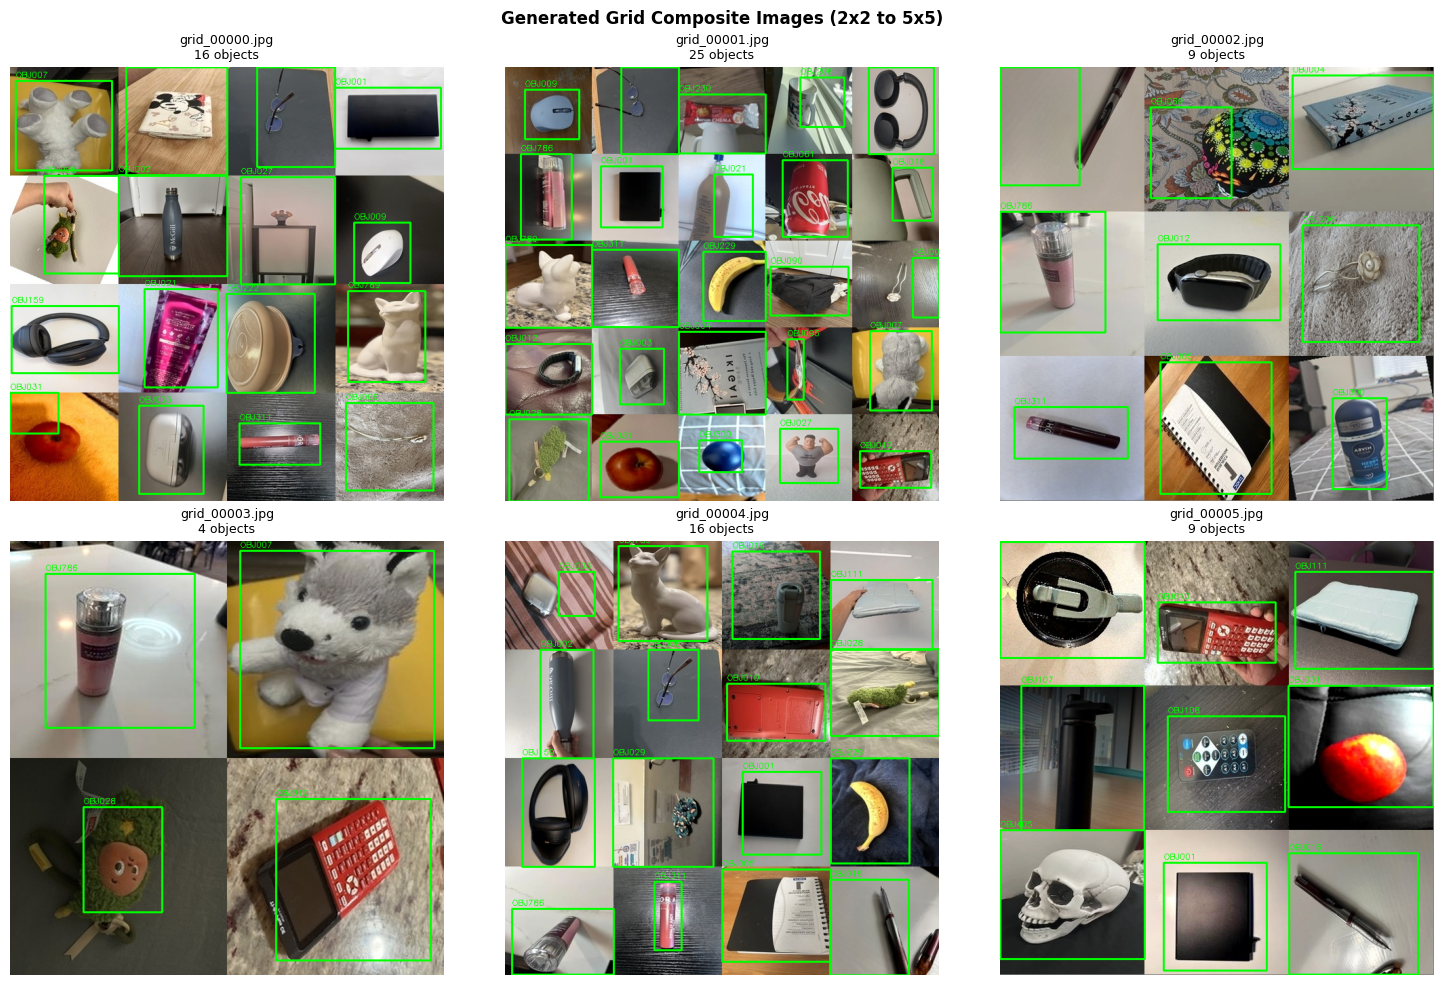

 Saved: grid_composite_samples.png


In [12]:
print(f"\nGrid Configuration:")
print(f"  Grid sizes: {GRID_SIZES} ({['x'.join([str(g)]*2) for g in GRID_SIZES]})")
print(f"  Grid weights: {GRID_WEIGHTS}")
print(f"  Output size: {OUTPUT_IMAGE_SIZE}")

if ALL_BBOXES and len(ALL_BBOXES) > 0:
    # Clean previous dataset
    if os.path.exists(YOLO_DATASET_DIR):
        shutil.rmtree(YOLO_DATASET_DIR)
    os.makedirs(YOLO_DATASET_DIR, exist_ok=True)

    # Generate dataset
    dataset_stats = generate_grid_dataset(
        ALL_BBOXES,
        YOLO_DATASET_DIR,
        num_train=NUM_TRAIN_IMAGES,
        num_val=NUM_VAL_IMAGES,
        num_test=NUM_TEST_IMAGES
    )

    # Create data.yaml
    print("\n" + "-" * 60)
    DATA_YAML_PATH = create_data_yaml(YOLO_DATASET_DIR)

    # Print summary
    print("\n" + "=" * 60)
    print("DATASET GENERATION SUMMARY")
    print("=" * 60)
    total_images = sum(s['images'] for s in dataset_stats.values())
    total_objects = sum(s['objects'] for s in dataset_stats.values())
    print(f"Total images generated: {total_images}")
    print(f"Total object instances: {total_objects}")
    print(f"Average objects per image: {total_objects/total_images:.2f}")

    # Grid size distribution
    print("\nGrid Size Distribution (Training):")
    for grid, count in sorted(dataset_stats['train']['grid_sizes'].items()):
        pct = count / dataset_stats['train']['images'] * 100
        print(f"  {grid}: {count} images ({pct:.1f}%)")

    print(f"\nDataset location: {YOLO_DATASET_DIR}")
    print(f"Config file: {DATA_YAML_PATH}")

    # Visualize samples
    print("\n" + "=" * 60)
    print("GRID COMPOSITE VISUALIZATION")
    print("=" * 60)
    visualize_grid_samples(YOLO_DATASET_DIR, num_samples=6)

else:
    print("No bounding boxes found. Please run Component 3 first.")
    DATA_YAML_PATH = None

# YOLO Training

In [13]:
def verify_dataset(data_yaml_path):
    """
    Verify dataset structure and contents before training.

    Args:
        data_yaml_path: Path to data.yaml

    Returns:
        bool: True if dataset is valid
    """
    print("Verifying dataset...")

    # Load data.yaml
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    root_path = data_config['path']

    checks_passed = True

    for split in ['train', 'val', 'test']:
        img_dir = os.path.join(root_path, 'images', split)
        label_dir = os.path.join(root_path, 'labels', split)

        # Count files
        img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

        print(f"  {split}: {len(img_files)} images, {len(label_files)} labels")

        # Check matching
        img_names = set(f.replace('.jpg', '') for f in img_files)
        label_names = set(f.replace('.txt', '') for f in label_files)

        if img_names != label_names:
            print(f"    ⚠ Mismatch: {len(img_names - label_names)} images without labels")
            checks_passed = False

    # Verify class count
    print(f"  Classes: {data_config['nc']}")
    print(f"  Class names: {data_config['names'][:5]}... (showing first 5)")

    if checks_passed:
        print("Dataset verification passed")
    else:
        print("Dataset verification has warnings")

    return checks_passed

# 5.2 Training Configuration

def get_training_config():
    """Get training configuration for YOLOv8."""

    config = {
        'model': YOLO_MODEL,           # YOLOv8s pretrained
        'data': DATA_YAML_PATH,        # Dataset config
        'epochs': EPOCHS,              # Number of epochs
        'batch': BATCH_SIZE,           # Batch size
        'imgsz': IMAGE_SIZE,           # Image size
        'device': 0 if device == 'cuda' else 'cpu',
        'workers': 2,                  # Data loader workers
        'patience': 15,                # Early stopping patience
        'save': True,                  # Save checkpoints
        'save_period': 10,             # Save every N epochs
        'project': OUTPUT_DIR,         # Output directory
        'name': 'yolov8_custom',       # Experiment name
        'exist_ok': True,              # Overwrite existing
        'pretrained': True,            # Use pretrained weights
        'optimizer': 'Adam',           # Optimizer
        'lr0': 0.001,                  # Initial learning rate
        'lrf': 0.01,                   # Final learning rate factor
        'momentum': 0.937,             # Momentum
        'weight_decay': 0.0005,        # Weight decay
        'warmup_epochs': 3,            # Warmup epochs
        'warmup_momentum': 0.8,        # Warmup momentum
        'box': 7.5,                    # Box loss weight
        'cls': 0.5,                    # Class loss weight
        'dfl': 1.5,                    # DFL loss weight
        'augment': True,               # Enable augmentation
        'verbose': True,               # Verbose output
    }

    return config

# Train YOLOv8 Model

def train_yolov8(config):
    """
    Train YOLOv8 model.

    Args:
        config: Training configuration dict

    Returns:
        tuple: (model, results)
    """
    print("\n" + "=" * 60)
    print("STARTING YOLOv8 TRAINING")
    print("=" * 60)

    # Print configuration
    print("\nTraining Configuration:")
    print(f"  Model:       {config['model']}")
    print(f"  Epochs:      {config['epochs']}")
    print(f"  Batch size:  {config['batch']}")
    print(f"  Image size:  {config['imgsz']}")
    print(f"  Device:      {config['device']}")
    print(f"  Optimizer:   {config['optimizer']}")
    print(f"  Initial LR:  {config['lr0']}")

    # Load model
    print("\nLoading YOLOv8 model...")
    model = YOLO(config['model'])

    # Start training
    print("\nTraining started...")
    print("-" * 60)

    start_time = time.time()

    results = model.train(
        data=config['data'],
        epochs=config['epochs'],
        batch=config['batch'],
        imgsz=config['imgsz'],
        device=config['device'],
        workers=config['workers'],
        patience=config['patience'],
        save=config['save'],
        save_period=config['save_period'],
        project=config['project'],
        name=config['name'],
        exist_ok=config['exist_ok'],
        pretrained=config['pretrained'],
        optimizer=config['optimizer'],
        lr0=config['lr0'],
        lrf=config['lrf'],
        momentum=config['momentum'],
        weight_decay=config['weight_decay'],
        warmup_epochs=config['warmup_epochs'],
        warmup_momentum=config['warmup_momentum'],
        box=config['box'],
        cls=config['cls'],
        dfl=config['dfl'],
        augment=config['augment'],
        verbose=config['verbose'],
    )

    training_time = time.time() - start_time

    print("-" * 60)
    print(f"\n Training complete in {training_time/60:.1f} minutes")

    return model, results, training_time

# 5.4 Print Training Results

def print_training_results(results, training_time):
    """Print training results summary."""

    print("\n" + "=" * 60)
    print("TRAINING RESULTS SUMMARY")
    print("=" * 60)

    print(f"\nTraining Time: {training_time/60:.1f} minutes")

    # Get best results
    results_dir = os.path.join(OUTPUT_DIR, 'yolov8_custom')

    # Check for results.csv
    results_csv = os.path.join(results_dir, 'results.csv')
    if os.path.exists(results_csv):
        import pandas as pd
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()  # Remove whitespace from column names

        # Get best epoch based on mAP50
        if 'metrics/mAP50(B)' in df.columns:
            best_idx = df['metrics/mAP50(B)'].idxmax()
            best_epoch = best_idx + 1

            print(f"\nBest Epoch: {best_epoch}")
            print(f"  mAP@0.5:      {df['metrics/mAP50(B)'].iloc[best_idx]:.4f}")
            print(f"  mAP@0.5:0.95: {df['metrics/mAP50-95(B)'].iloc[best_idx]:.4f}")
            print(f"  Precision:    {df['metrics/precision(B)'].iloc[best_idx]:.4f}")
            print(f"  Recall:       {df['metrics/recall(B)'].iloc[best_idx]:.4f}")

    # Model paths
    best_model = os.path.join(results_dir, 'weights', 'best.pt')
    last_model = os.path.join(results_dir, 'weights', 'last.pt')

    print(f"\nModel Weights:")
    print(f"  Best:  {best_model}")
    print(f"  Last:  {last_model}")

    if os.path.exists(best_model):
        size_mb = os.path.getsize(best_model) / (1024 * 1024)
        print(f"  Size:  {size_mb:.1f} MB")

    return best_model

# 5.5 Plot Training Curves

def plot_training_curves(results_dir):
    """Plot training loss and metrics curves."""

    results_csv = os.path.join(results_dir, 'results.csv')

    if not os.path.exists(results_csv):
        print("⚠ results.csv not found")
        return

    import pandas as pd
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Box Loss
    ax1 = axes[0, 0]
    if 'train/box_loss' in df.columns:
        ax1.plot(df['epoch'], df['train/box_loss'], label='Train', color='blue')
    if 'val/box_loss' in df.columns:
        ax1.plot(df['epoch'], df['val/box_loss'], label='Val', color='orange')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Box Loss')
    ax1.set_title('Box Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Class Loss
    ax2 = axes[0, 1]
    if 'train/cls_loss' in df.columns:
        ax2.plot(df['epoch'], df['train/cls_loss'], label='Train', color='blue')
    if 'val/cls_loss' in df.columns:
        ax2.plot(df['epoch'], df['val/cls_loss'], label='Val', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Class Loss')
    ax2.set_title('Classification Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # mAP
    ax3 = axes[1, 0]
    if 'metrics/mAP50(B)' in df.columns:
        ax3.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
    if 'metrics/mAP50-95(B)' in df.columns:
        ax3.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='red')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('mAP')
    ax3.set_title('Mean Average Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Precision & Recall
    ax4 = axes[1, 1]
    if 'metrics/precision(B)' in df.columns:
        ax4.plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='blue')
    if 'metrics/recall(B)' in df.columns:
        ax4.plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='orange')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Value')
    ax4.set_title('Precision & Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle('YOLOv8 Training Curves', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('training_curves_yolo.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(" Saved: training_curves_yolo.png")

Verifying dataset...
  train: 3500 images, 3500 labels
  val: 400 images, 400 labels
  test: 100 images, 100 labels
  Classes: 39
  Class names: ['OBJ001', 'OBJ002', 'OBJ003', 'OBJ004', 'OBJ005']... (showing first 5)
Dataset verification passed

STARTING YOLOv8 TRAINING

Training Configuration:
  Model:       yolov8s.pt
  Epochs:      50
  Batch size:  16
  Image size:  640
  Device:      0
  Optimizer:   Adam
  Initial LR:  0.001

Loading YOLOv8 model...

Training started...
------------------------------------------------------------
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=

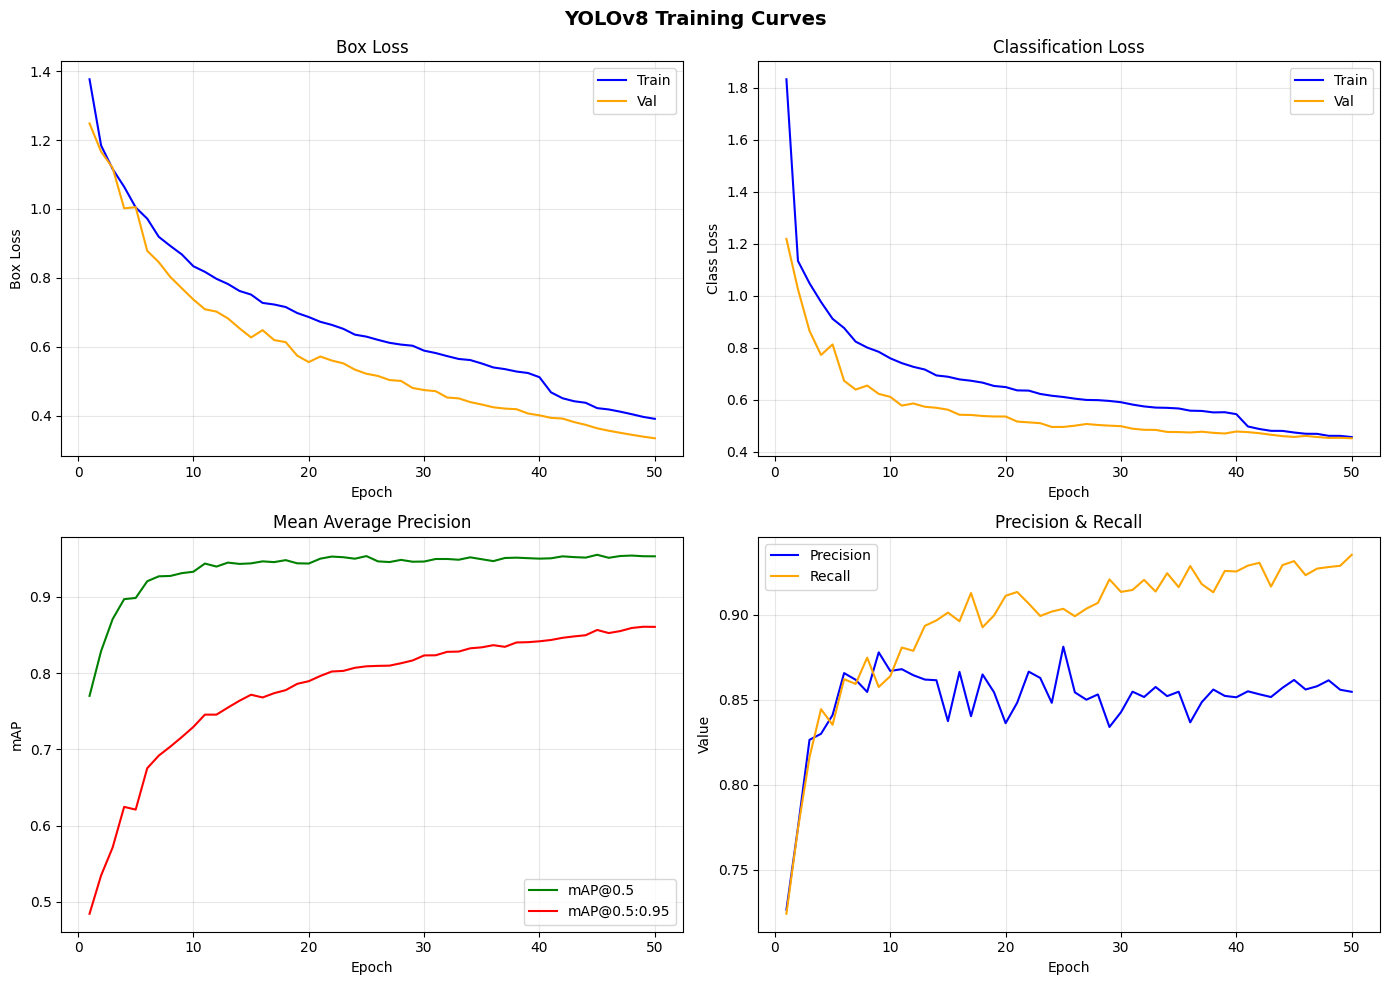

 Saved: training_curves_yolo.png


In [14]:
if DATA_YAML_PATH and os.path.exists(DATA_YAML_PATH):
    # Verify dataset
    verify_dataset(DATA_YAML_PATH)

    # Get training configuration
    training_config = get_training_config()

    # Train model
    trained_model, training_results, training_time = train_yolov8(training_config)

    # Print results
    BEST_MODEL_PATH = print_training_results(training_results, training_time)

    # Plot training curves
    print("\n" + "=" * 60)
    print("TRAINING CURVES")
    print("=" * 60)
    results_dir = os.path.join(OUTPUT_DIR, 'yolov8_custom')
    plot_training_curves(results_dir)

else:
    print("data.yaml not found. Please run Component 4 first.")
    BEST_MODEL_PATH = None
    trained_model = None

# Eval and Inference

In [28]:
def evaluate_model(model_path, data_yaml_path):
    """
    Evaluate trained model on test set.

    Args:
        model_path: Path to best.pt weights
        data_yaml_path: Path to data.yaml

    Returns:
        dict: Evaluation metrics
    """
    print("Loading trained model...")
    model = YOLO(model_path)

    print("Evaluating on test set...")
    results = model.val(
        data=data_yaml_path,
        split='test',
        batch=BATCH_SIZE,
        imgsz=IMAGE_SIZE,
        device=0 if device == 'cuda' else 'cpu',
        verbose=True
    )

    return results

# Print Evaluation Results

def print_evaluation_results(results):
    """Print detailed evaluation results."""

    print("\n" + "=" * 60)
    print("TEST SET EVALUATION RESULTS")
    print("=" * 60)

    # Overall metrics
    print("\nOverall Metrics:")
    print(f"  mAP@0.5:      {results.box.map50:.4f}")
    print(f"  mAP@0.5:0.95: {results.box.map:.4f}")
    print(f"  Precision:    {results.box.mp:.4f}")
    print(f"  Recall:       {results.box.mr:.4f}")

    # Per-class AP
    print("\n" + "-" * 60)
    print("Per-Class Average Precision (AP@0.5)")
    print("-" * 60)
    print(f"{'Class':<12} {'AP@0.5':>10} {'Object Name':<30}")
    print("-" * 60)

    ap50_per_class = results.box.ap50

    for idx, ap in enumerate(ap50_per_class):
        if idx < len(CLASS_IDS):
            class_id = CLASS_IDS[idx]
            readable_name = CLASS_MAPPING.get(class_id, 'Unknown')[:28]
            print(f"{class_id:<12} {ap:>10.4f} {readable_name:<30}")

    # Best and worst classes
    print("\n" + "-" * 60)
    best_idx = np.argmax(ap50_per_class)
    worst_idx = np.argmin(ap50_per_class)

    best_class = CLASS_IDS[best_idx] if best_idx < len(CLASS_IDS) else f"Class_{best_idx}"
    worst_class = CLASS_IDS[worst_idx] if worst_idx < len(CLASS_IDS) else f"Class_{worst_idx}"

    print(f"Best Class:  {best_class} ({CLASS_MAPPING.get(best_class, 'Unknown')}) - AP: {ap50_per_class[best_idx]:.4f}")
    print(f"Worst Class: {worst_class} ({CLASS_MAPPING.get(worst_class, 'Unknown')}) - AP: {ap50_per_class[worst_idx]:.4f}")

    return {
        'map50': results.box.map50,
        'map': results.box.map,
        'precision': results.box.mp,
        'recall': results.box.mr,
        'ap50_per_class': ap50_per_class
    }

# Run Inference on Single Image

def run_inference(model, image_path, conf_threshold=0.25):
    """
    Run inference on a single image.

    Args:
        model: YOLO model
        image_path: Path to image
        conf_threshold: Confidence threshold

    Returns:
        list: List of detections [(class_id, class_name, confidence, bbox), ...]
    """
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        imgsz=IMAGE_SIZE,
        device=0 if device == 'cuda' else 'cpu',
        verbose=False
    )

    detections = []

    for result in results:
        boxes = result.boxes

        for i in range(len(boxes)):
            # Get class index and confidence
            cls_idx = int(boxes.cls[i].item())
            conf = float(boxes.conf[i].item())

            # Get bounding box (xyxy format)
            bbox = boxes.xyxy[i].cpu().numpy().astype(int).tolist()

            # Get class ID (OBJxxx)
            class_id = IDX_TO_CLASS.get(cls_idx, f"Unknown_{cls_idx}")
            readable_name = CLASS_MAPPING.get(class_id, 'Unknown')

            detections.append({
                'class_idx': cls_idx,
                'class_id': class_id,
                'class_name': readable_name,
                'confidence': conf,
                'bbox': bbox  # [x1, y1, x2, y2]
            })

    return detections

# Print Detection Results

def print_detections(image_path, detections):
    """Print detection results for an image."""

    print(f"\nImage: {os.path.basename(image_path)}")
    print("-" * 60)

    if len(detections) == 0:
        print("  No objects detected")
        return

    print(f"{'Object ID':<12} {'Object Name':<25} {'Conf':>8} {'Location (x1,y1,x2,y2)':<25}")
    print("-" * 60)

    for det in detections:
        bbox_str = f"[{det['bbox'][0]}, {det['bbox'][1]}, {det['bbox'][2]}, {det['bbox'][3]}]"
        print(f"{det['class_id']:<12} {det['class_name'][:23]:<25} {det['confidence']:>7.2%} {bbox_str:<25}")

    print(f"\nTotal objects detected: {len(detections)}")



# Visualize Detection Results

def visualize_detection(model, image_path, conf_threshold=0.25, save_path=None):
    """
    Visualize detection results on an image.

    Args:
        model: YOLO model
        image_path: Path to image
        conf_threshold: Confidence threshold
        save_path: Path to save visualization (optional)

    Returns:
        PIL.Image: Annotated image
    """
    # Run inference
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        imgsz=IMAGE_SIZE,
        device=0 if device == 'cuda' else 'cpu',
        verbose=False
    )

    # Load original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Define colors for different classes
    np.random.seed(42)
    colors = {i: tuple(np.random.randint(0, 255, 3).tolist()) for i in range(NUM_CLASSES)}

    # Draw detections
    for result in results:
        boxes = result.boxes

        for i in range(len(boxes)):
            cls_idx = int(boxes.cls[i].item())
            conf = float(boxes.conf[i].item())
            bbox = boxes.xyxy[i].cpu().numpy().astype(int)

            x1, y1, x2, y2 = bbox
            color = colors.get(cls_idx, (0, 255, 0))

            # Get class ID
            class_id = IDX_TO_CLASS.get(cls_idx, f"Unk_{cls_idx}")

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            # Draw label background
            label = f"{class_id} {conf:.2f}"
            (label_w, label_h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(img, (x1, y1 - label_h - 10), (x1 + label_w, y1), color, -1)

            # Draw label text
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Convert to PIL
    img_pil = Image.fromarray(img)

    if save_path:
        img_pil.save(save_path)

    return img_pil

# Run Inference on Multiple Test Images

def run_inference_on_test_set(model, data_yaml_path, num_samples=9):
    """
    Run inference on sample test images and visualize results.

    Args:
        model: YOLO model
        data_yaml_path: Path to data.yaml
        num_samples: Number of samples to visualize
    """
    # Load data config
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    test_img_dir = os.path.join(data_config['path'], 'images', 'test')
    test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.jpg')])[:num_samples]

    cols = 3
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    print("\n" + "=" * 60)
    print("INFERENCE ON TEST IMAGES")
    print("=" * 60)

    for idx, img_file in enumerate(test_images):
        img_path = os.path.join(test_img_dir, img_file)

        # Run inference
        detections = run_inference(model, img_path)

        # Print detections
        print_detections(img_path, detections)

        # Visualize
        annotated_img = visualize_detection(model, img_path)

        axes[idx].imshow(annotated_img)
        axes[idx].set_title(f"{img_file}\n{len(detections)} objects", fontsize=9)
        axes[idx].axis('off')

    # Hide empty subplots
    for idx in range(len(test_images), len(axes)):
        axes[idx].axis('off')

    plt.suptitle("YOLOv8 Detection Results on Test Images", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('detection_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n Saved: detection_results.png")


# Generate Detection Report

def generate_detection_report(model, data_yaml_path, output_path='detection_report.txt'):
    """
    Generate a text report of all detections on test set.

    Args:
        model: YOLO model
        data_yaml_path: Path to data.yaml
        output_path: Path to save report
    """
    # Load data config
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    test_img_dir = os.path.join(data_config['path'], 'images', 'test')
    test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith('.jpg')])

    report_lines = []
    report_lines.append("=" * 70)
    report_lines.append("YOLOV8 OBJECT DETECTION REPORT")
    report_lines.append("=" * 70)
    report_lines.append(f"Model: {BEST_MODEL_PATH}")
    report_lines.append(f"Test Images: {len(test_images)}")
    report_lines.append(f"Classes: {NUM_CLASSES}")
    report_lines.append("=" * 70)
    report_lines.append("")

    total_detections = 0
    class_counts = defaultdict(int)

    for img_file in test_images:
        img_path = os.path.join(test_img_dir, img_file)
        detections = run_inference(model, img_path)

        report_lines.append(f"Image: {img_file}")
        report_lines.append("-" * 50)

        if len(detections) == 0:
            report_lines.append("  No objects detected")
        else:
            for det in detections:
                bbox = det['bbox']
                report_lines.append(
                    f"  {det['class_id']} ({det['class_name'][:20]}) - "
                    f"Conf: {det['confidence']:.2%} - "
                    f"Location: [{bbox[0]}, {bbox[1]}, {bbox[2]}, {bbox[3]}]"
                )
                class_counts[det['class_id']] += 1
                total_detections += 1

        report_lines.append("")

    # Summary
    report_lines.append("=" * 70)
    report_lines.append("SUMMARY")
    report_lines.append("=" * 70)
    report_lines.append(f"Total Detections: {total_detections}")
    report_lines.append(f"Average per Image: {total_detections / len(test_images):.2f}")
    report_lines.append("")
    report_lines.append("Detections per Class:")
    for class_id, count in sorted(class_counts.items()):
        report_lines.append(f"  {class_id}: {count}")

    # Write report
    with open(output_path, 'w') as f:
        f.write('\n'.join(report_lines))

    print(f" Detection report saved: {output_path}")

    return total_detections, class_counts


Loading trained model...

------------------------------------------------------------
Loading trained model...
Evaluating on test set...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (NVIDIA A100-SXM4-80GB, 81153MiB)
Model summary (fused): 73 layers, 11,140,677 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2466.3±649.1 MB/s, size: 153.1 KB)
val: Scanning /content/yolo_dataset/labels/test... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 1.4Kit/s 0.1s
val: New cache created: /content/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.7it/s 2.6s
                   all        100       1230      0.859      0.931       0.95      0.863
                OBJ001         29         29      0.973          1      0.995       0.93
                OBJ002         21         21      0.839      0.952      0.944      0.854
              

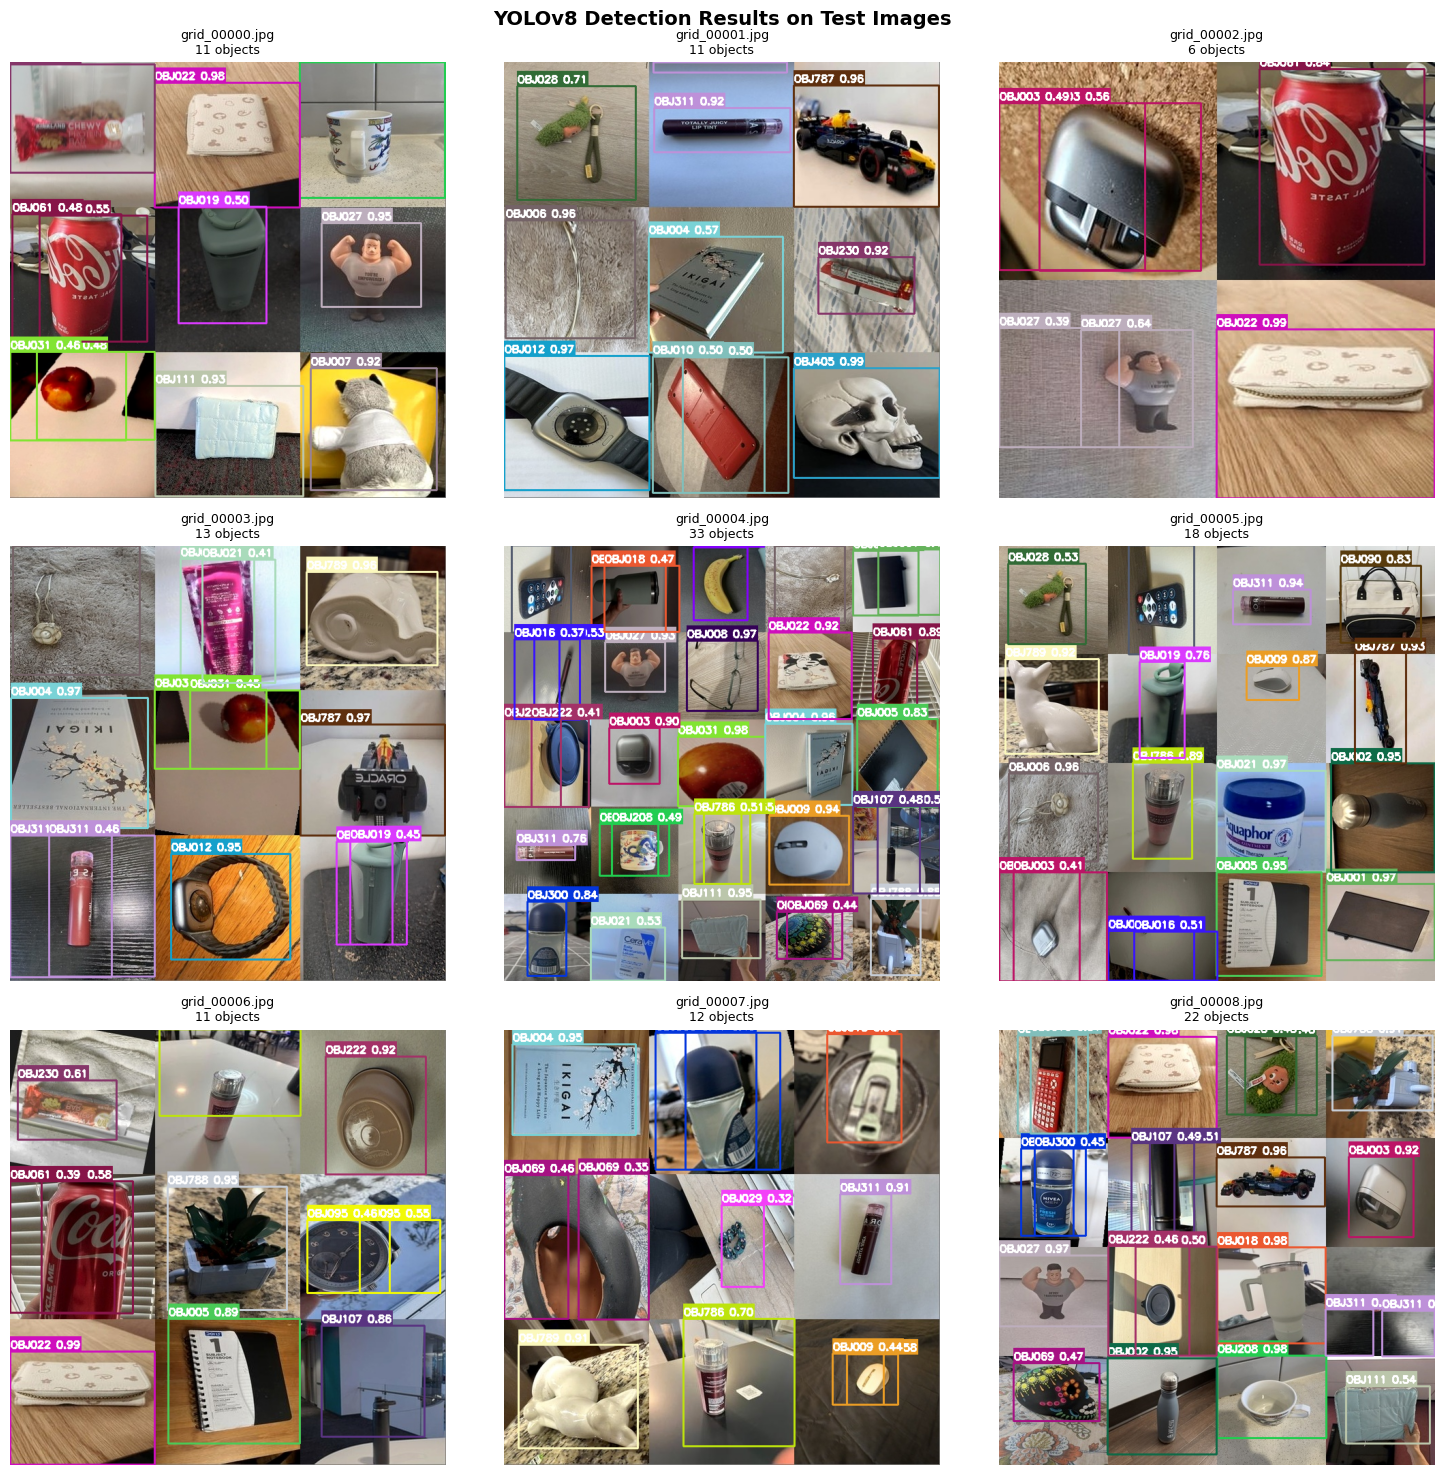


 Saved: detection_results.png

------------------------------------------------------------
Generating detection report...
 Detection report saved: detection_report.txt

EVALUATION COMPLETE
mAP@0.5: 0.9501
Total test detections: 1618


In [17]:
if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    # Load trained model
    print("\nLoading trained model...")
    trained_model = YOLO(BEST_MODEL_PATH)

    # Evaluate on test set
    print("\n" + "-" * 60)
    eval_results = evaluate_model(BEST_MODEL_PATH, DATA_YAML_PATH)
    eval_metrics = print_evaluation_results(eval_results)

    # Run inference on sample test images
    print("\n" + "-" * 60)
    run_inference_on_test_set(trained_model, DATA_YAML_PATH, num_samples=9)

    # Generate detection report
    print("\n" + "-" * 60)
    print("Generating detection report...")
    total_det, class_det = generate_detection_report(trained_model, DATA_YAML_PATH)

    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE")
    print("=" * 60)
    print(f"mAP@0.5: {eval_metrics['map50']:.4f}")
    print(f"Total test detections: {total_det}")

else:
    print("Best model not found.")

In [19]:
summary = create_final_summary()

# Export model (optional - can be slow)
print("\n" + "-" * 60)
print("MODEL EXPORT")
print("-" * 60)
print("Skipping ONNX export to save time. To export, run:")
print("  exported = export_model(BEST_MODEL_PATH, ['onnx'])")

# Create download package
download_zip = create_download_package()

# Print usage instructions
print_usage_instructions()

# Final message
print("\n" + "=" * 70)
print("PIPELINE COMPLETE!")
print("=" * 70)
print(f"""
Files ready for download:
  1. {download_zip} - Contains model, results, and visualizations
  2. {BEST_MODEL_PATH} - Best model weights (for inference)

To download in Colab:
  from google.colab import files
  files.download('{download_zip}')

To run inference on a new image:
  detections = detect_objects('path/to/your/image.jpg')
""")


FINAL PIPELINE SUMMARY
YOLOv8 OBJECT DETECTION PIPELINE - FINAL REPORT

1. DATASET SUMMARY
--------------------------------------------------
   Total Classes: 39
   Single-Object Images: 4107
   Composite Images Generated:
     - Training:   3500
     - Validation: 400
     - Test:       100
   Objects per Image: 2-5
   Canvas Size: 640x640

2. MODEL SUMMARY
--------------------------------------------------
   Base Model: yolov8s.pt
   Training Epochs: 50
   Batch Size: 16
   Image Size: 640
   Optimizer: Adam
   Learning Rate: 0.001

3. RESULTS SUMMARY
--------------------------------------------------
   (Results not available - run evaluation first)

4. CLASS MAPPING
--------------------------------------------------
   Index    Object ID    Object Name                   
   --------------------------------------------------
   0        OBJ001       Trigger Wallet                
   1        OBJ002       Water Bottle-Grey             
   2        OBJ003       Ear buds            

# Gradio Interactive Web App for YOLOv8 Object Detection

**Complete Gradio App Code**

In [20]:
!pip install gradio ultralytics opencv-python pillow pandas numpy

In [21]:
import gradio as gr
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import pandas as pd

# Load your trained YOLOv8 model
MODEL_PATH = BEST_MODEL_PATH  # Update this path to your model
model = YOLO(MODEL_PATH)

# Class ID to OBJ ID mapping (0->OBJ001, 1->OBJ002, ..., 38->OBJ789)
def get_obj_id(class_idx):
    """Convert class index to OBJ ID format"""
    # Use the globally defined CLASS_IDS list
    obj_ids = CLASS_IDS

    return obj_ids[class_idx] if class_idx < len(obj_ids) else f'OBJ{class_idx:03d}'


def detect_single_object(image, conf_threshold):
    """
    Detect single object in image
    Args:
        image: PIL Image
        conf_threshold: Confidence threshold for detection
    Returns:
        annotated_image, detection_info
    """
    if image is None:
        return None, "Please upload an image"

    # Run inference
    results = model(image, conf=conf_threshold)

    # Get the first result
    result = results[0]

    # Check if any objects detected
    if len(result.boxes) == 0:
        return image, "⚠️ No objects detected. Try lowering the confidence threshold."

    # Get annotated image
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Get detection details for the highest confidence detection
    boxes = result.boxes
    best_idx = boxes.conf.argmax()

    class_id = int(boxes.cls[best_idx])
    confidence = float(boxes.conf[best_idx])
    bbox = boxes.xyxy[best_idx].cpu().numpy()
    obj_id = get_obj_id(class_id)
    class_name = model.names[class_id]

    # Format detection info
    detection_info = f"""
    🎯 **SINGLE OBJECT DETECTION RESULT**

    ✅ **Object ID**: {obj_id}
    📝 **Class Name**: {class_name}
    📊 **Confidence**: {confidence:.2%}
    📍 **Bounding Box**: [{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]

    ---
    **Total Objects Detected**: {len(boxes)}
    ℹ️ Showing highest confidence detection
    """

    return annotated_img, detection_info

In [22]:
def detect_multiple_objects(image, conf_threshold, iou_threshold):
    """
    Detect multiple objects in image
    Args:
        image: PIL Image
        conf_threshold: Confidence threshold
        iou_threshold: IoU threshold for NMS
    Returns:
        annotated_image, detection_table, summary_text
    """
    if image is None:
        return None, None, "Please upload an image"

    # Run inference
    results = model(image, conf=conf_threshold, iou=iou_threshold)
    result = results[0]

    # Check if any objects detected
    if len(result.boxes) == 0:
        return image, None, "⚠️ No objects detected. Try lowering the confidence threshold."

    # Get annotated image
    annotated_img = result.plot()
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Prepare detection data for table
    detection_data = []
    boxes = result.boxes

    for i in range(len(boxes)):
        class_id = int(boxes.cls[i])
        confidence = float(boxes.conf[i])
        bbox = boxes.xyxy[i].cpu().numpy()
        obj_id = get_obj_id(class_id)
        class_name = model.names[class_id]

        detection_data.append({
            'Detection #': i + 1,
            'Object ID': obj_id,
            'Class Name': class_name,
            'Confidence': f"{confidence:.2%}",
            'Bounding Box (x1, y1, x2, y2)': f"[{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]"
        })

    # Create DataFrame
    df = pd.DataFrame(detection_data)

    # Summary statistics
    avg_conf = boxes.conf.mean()
    unique_classes = len(set([int(c) for c in boxes.cls]))

    summary = f"""
    🎯 **MULTIPLE OBJECT DETECTION SUMMARY**

    ✅ **Total Objects Detected**: {len(boxes)}
    🏷️ **Unique Classes**: {unique_classes}
    📊 **Average Confidence**: {avg_conf:.2%}
    ⚙️ **Confidence Threshold**: {conf_threshold}
    🔄 **IoU Threshold**: {iou_threshold}

    ---
    📋 Detailed detection results shown in table below
    """

    return annotated_img, df, summary

In [31]:
# Custom CSS for better UI
custom_css = """
    .gradio-container {
        font-family: 'Arial', sans-serif;
    }
    .output-image {
        border: 2px solid #4CAF50;
        border-radius: 8px;
    }
    footer {
        display: none !important;
    }
"""

# Create Gradio Interface with Tabs
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    # 🔍 YOLOv8 Object Detection System
    ### Milestone 3: Live Demonstration

    This interactive demo showcases **custom-trained YOLOv8** model for multi-object detection.
    - **39 Object Classes** (OBJ001 through OBJ789)
    - **Model Performance**: mAP@0.5 = 95.2%, mAP@0.5:0.95 = 86.5%
    - **Trained on**: 4,000 synthetic composite images

    ---
    """)

    with gr.Tabs():
        # Tab 1: Single Object Detection
        with gr.Tab("🎯 Single Object Detection"):
            gr.Markdown("""
            ### Test Case A: Single Object Identification
            Upload an image containing **one object** and the model will identify its **Object ID** and **Class Name**.
            """)

            with gr.Row():
                with gr.Column(scale=1):
                    single_input = gr.Image(type="pil", label="Upload Single Object Image")
                    single_conf = gr.Slider(
                        minimum=0.1,
                        maximum=1.0,
                        value=0.25,
                        step=0.05,
                        label="Confidence Threshold"
                    )
                    single_btn = gr.Button("🔍 Detect Object", variant="primary", size="lg")

                with gr.Column(scale=1):
                    single_output_img = gr.Image(label="Detection Result", elem_classes="output-image")
                    single_output_text = gr.Markdown(label="Detection Details")

            single_btn.click(
                fn=detect_single_object,
                inputs=[single_input, single_conf],
                outputs=[single_output_img, single_output_text]
            )

            # Example images for single object
            gr.Markdown("### 📸 Try Example Images:")
            gr.Examples(
                examples=[
                    ["example_single_1.jpg", 0.25],
                    ["example_single_2.jpg", 0.25],
                ],
                inputs=[single_input, single_conf],
                label="Click to load example"
            )

        # Tab 2: Multiple Object Detection
        with gr.Tab("🎯🎯🎯 Multiple Object Detection"):
            gr.Markdown("""
            ### Test Case B: Multiple Object Detection & Localization
            Upload an image with **multiple objects** and the model will:
            - Identify all **Object IDs**
            - Provide **Bounding Box** coordinates for each object
            - Display **Confidence Scores**
            """)

            with gr.Row():
                with gr.Column(scale=1):
                    multi_input = gr.Image(type="pil", label="Upload Multi-Object Image")

                    with gr.Row():
                        multi_conf = gr.Slider(
                            minimum=0.1,
                            maximum=1.0,
                            value=0.25,
                            step=0.05,
                            label="Confidence Threshold"
                        )
                        multi_iou = gr.Slider(
                            minimum=0.1,
                            maximum=1.0,
                            value=0.5,
                            step=0.05,
                            label="IoU Threshold"
                        )

                    multi_btn = gr.Button("🔍 Detect All Objects", variant="primary", size="lg")

                with gr.Column(scale=1):
                    multi_output_img = gr.Image(label="Detection Result", elem_classes="output-image")
                    multi_output_summary = gr.Markdown(label="Summary")

            multi_output_table = gr.DataFrame(
                label="📊 Detailed Detection Results",
                headers=['Detection #', 'Object ID', 'Class Name', 'Confidence', 'Bounding Box (x1, y1, x2, y2)']
,                wrap=True
            )

            multi_btn.click(
                fn=detect_multiple_objects,
                inputs=[multi_input, multi_conf, multi_iou],
                outputs=[multi_output_img, multi_output_table, multi_output_summary]
            )

            # Example images for multiple objects
            gr.Markdown("### 📸 Try Example Images:")
            gr.Examples(
                examples=[
                    ["example_multi_1.jpg", 0.25, 0.5],
                    ["example_multi_2.jpg", 0.25, 0.5],
                ],
                inputs=[multi_input, multi_conf, multi_iou],
                label="Click to load example"
            )

    # Footer
    gr.Markdown("""
    ---
    ### 📊 Model Information
    - **Architecture**: YOLOv8s (11.1M parameters)
    - **Dataset**: 4,000 synthetic images (3,500 train / 400 val / 100 test)
    - **Classes**: 39 objects (Trigger Wallet, Water Bottle, Ear buds, Book, etc.)
    - **Performance Metrics**:
        - Precision: 84.6%
        - Recall: 92.3%
        - mAP@0.5: 95.2%
        - mAP@0.5:0.95: 86.5%

    **Developed by**:Zhengxin Chen - Yi Liu - Samet Temurcin - Greta Wang | Northeastern University | Milestone 3 Submission
    """)

# Launch the app
if __name__ == "__main__":
    demo.launch(
        share=True,  # Creates public link for 72 hours
        debug=True,
        show_error=True
    )

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f905a0881ba833861e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/httptools_impl.py", line 416, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1138, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/error


0: 640x640 (no detections), 71.7ms
Speed: 3.3ms preprocess, 71.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 OBJ010, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f905a0881ba833861e.gradio.live
